Comments:
Score:100
1. You are really good at selling your quant works by using clear pictures and concise explainations. Quant is not only math and coding, selling is also important. 
1. Perfect research proposal and clear research target
2. Good data template used for the data visualization
3. Nice data clean work

# HW4 KAGGLE数据集初探
_黎睿 2020201623_

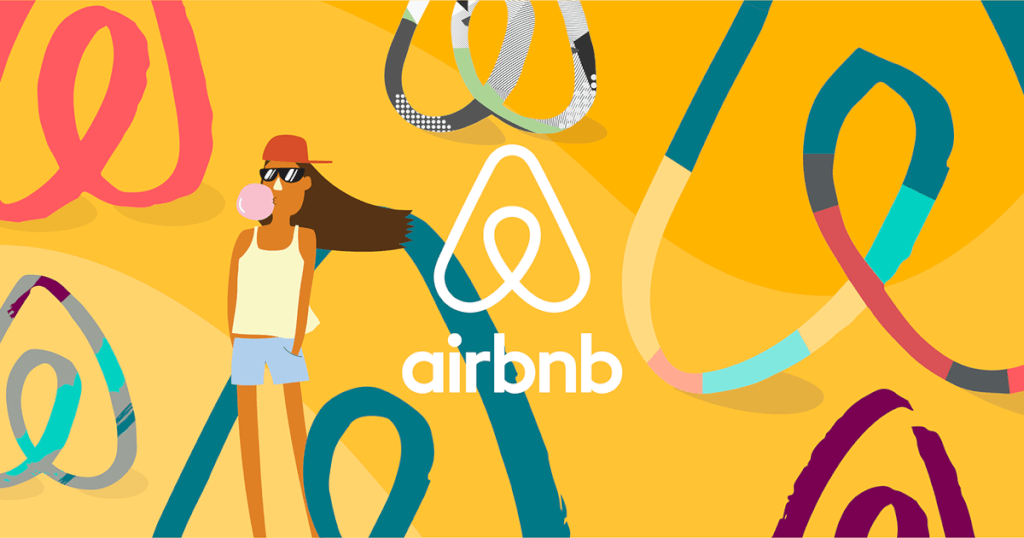

## 数据集相关

本次作业选用的数据集为2019年纽约市Airbnb房屋租赁价格数据集(https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data) 。<br/>
该数据集包含了有关租赁房屋的丰富信息，包括但不限于：租赁价格，租赁房屋的地理位置。<br/>

## 研究主题

本次作业旨在探讨影响纽约市房屋租赁价格的主要因素。

## 前期准备

In [4]:
#安装所需的程序包
#!pip install folium

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

conda 4.12.0 requires ruamel_yaml_conda>=0.11.14, which is not installed.
selenium 4.8.3 requires urllib3[socks]~=1.26, but you'll have urllib3 1.25.11 which is incompatible.



  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.15
    Uninstalling urllib3-1.26.15:
      Successfully uninstalled urllib3-1.26.15


In [5]:
#数据处理
import pandas as pd
import numpy as np

#绘图
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import HeatMap

#回归
import statsmodels.formula.api as smf

## 数据预处理

In [6]:
#数据读入和观察
airbnb_nyc = pd.read_csv('D:/Library/spring_backup/AI/HW4/data/AB_NYC_2019.csv') 
airbnb_nyc.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [7]:
#数据清洗

#除去不必要的列
airbnb_nyc.drop(['name','id','host_name','last_review'], axis=1, inplace=True)    

#观察各变量各有多少空缺值
airbnb_nyc.isnull().sum()

#所有的空缺值均属于同一变量"reviews_per_month",使用0替换空缺值
airbnb_nyc.fillna({'reviews_per_month':0}, inplace=True)

#剔除价格小于等于0的异常值
airbnb_nyc = airbnb_nyc.loc[airbnb_nyc['price'] > 0]

In [8]:
#描述性统计
airbnb_nyc.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,6.762203e+07,40.728953,-73.952176,152.755053,7.029887,23.271991,1.090800,7.144628,112.779498
std,7.861666e+07,0.054532,0.046159,240.170260,20.512224,44.551331,1.597213,32.956185,131.627271
min,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,7.817310e+06,40.690100,-73.983080,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,3.079257e+07,40.723080,-73.955685,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,1.074344e+08,40.763120,-73.936290,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


##  特征工程

为了后续数据可视化和回归的方便，我们需要将非数值的变量处理为可处理的数值变量:

In [9]:
#数值化
airbnb_num = airbnb_nyc.copy()
airbnb_num['room_type']=airbnb_num['room_type'].factorize()[0]
airbnb_num['neighbourhood_group']=airbnb_num['neighbourhood_group'].factorize()[0]
airbnb_num['neighbourhood'] = airbnb_num['neighbourhood'].factorize()[0]

#回归用数据集构造
# 注意!!
# 变量的选择基于后续的数据分析（如：协方差矩阵）的结果，之所以将回归数据集的构造放置于此处是为了体现整体形式的工整
feature_columns = ['neighbourhood_group','room_type','price','minimum_nights','calculated_host_listings_count','availability_365'] #回归使用变量及自变量
airbnb_reg = airbnb_num[feature_columns] #回归用数据集

## 数据分析及数据可视化

通过观察下述协方差矩阵，我们在数据可视化部分集中关注`房屋类型(room_type)`对价格的影响，同时出于实际经验，也考察`地区(neighbourhood_group)`对价格的影响。

<AxesSubplot:>

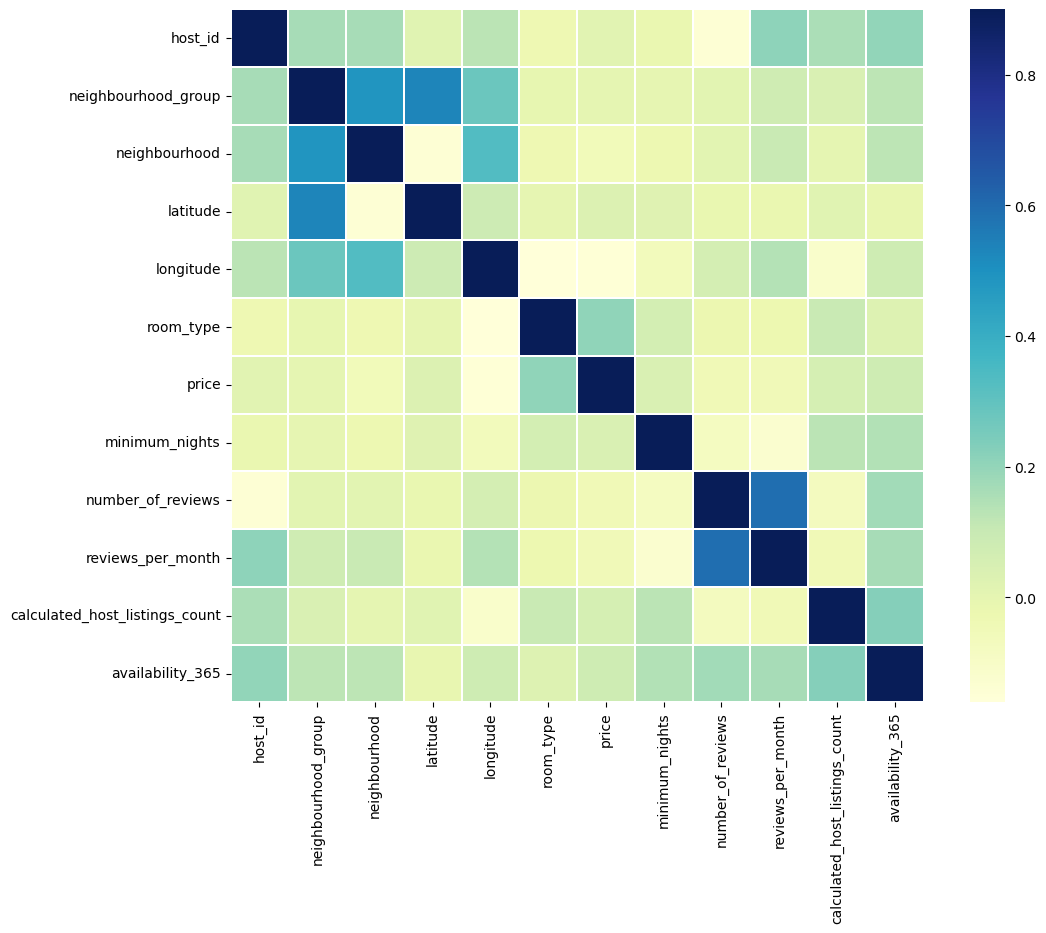

In [54]:
# 协方差矩阵绘制

corrmat = airbnb_num.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,cmap="YlGnBu",linecolor="white",linewidths=0.2)

### 房屋类型(Room Type)

首先统计不同`房屋类型（room type）`在数据集中的出现频次。如下图所示，`Entire home/apt`，`Private room`出现频次较多且二者出现频次相近，而`Shared room`的出现频次和前二者有较大差距：

-----Room Type-----
Entire home/apt    25407
Private room       22319
Shared room         1158
Name: room_type, dtype: int64
-------------------


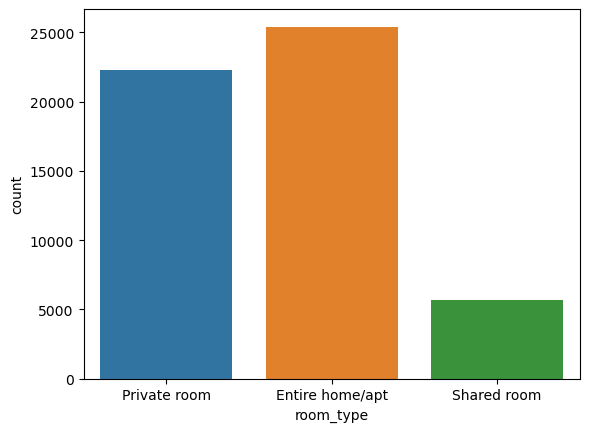

In [71]:
#频数统计
print("-----Room Type-----")
print(airbnb_nyc['room_type'].value_counts()) #不同room_type出现的频率
print("-------------------")

#频数直方图
ax = sns.countplot(x="room_type", data=airbnb_nyc)
plt.show()

通过绘制不同`房屋类型(room type)`下的价格的概率密度函数，可知`Entire home/apt`的整体价格最高，`Private room`其次，`Shared room`最低。`Private room`和`Shared room`价格相差较小，且价格分布更为集中，`Entire home/apt`同剩余房屋类型的价格相差较大，且价格分布更为平缓。

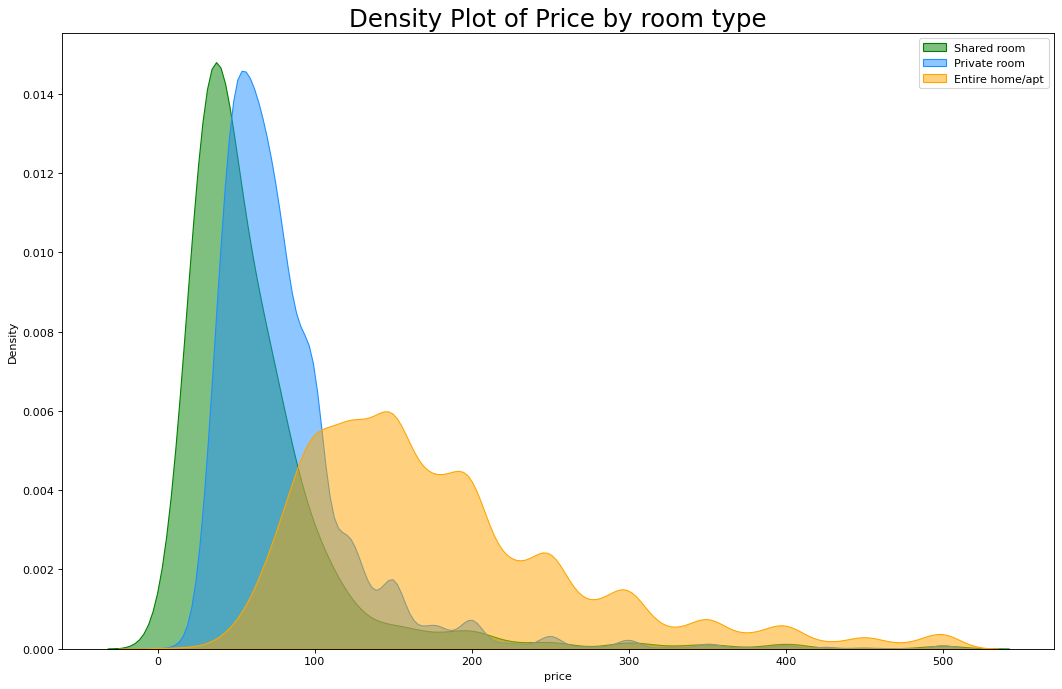

In [74]:
# 密度图

#大部分价格均不超过500，而少数离群值数值偏差较大，会造成很长的拖尾，故在此处删去
nyc = airbnb_nyc[airbnb_nyc['price']<=500]

plt.figure(figsize=(16,10),dpi=80)
sns.kdeplot(nyc.loc[nyc['room_type']=="Shared room",'price'],fill=True,color='g',label = 'Shared room',alpha=.5)
sns.kdeplot(nyc.loc[nyc['room_type']=="Private room",'price'],fill=True,color='dodgerblue',label = 'Private room',alpha=.5)
sns.kdeplot(nyc.loc[nyc['room_type']=="Entire home/apt",'price'],fill=True,color='orange',label = 'Entire home/apt',alpha=.5)



plt.title('Density Plot of Price by room type', fontsize = 22)
plt.legend()
plt.show()

通过绘制不同`房屋类型(room type)`样本的地理分布图，我们发现：尽管不同`房屋类型(room type)`样本整体价格存在差异，但是不同`房屋类型(room type)`的样本在地区间的分布较为均匀，不存在明显的地理差异。

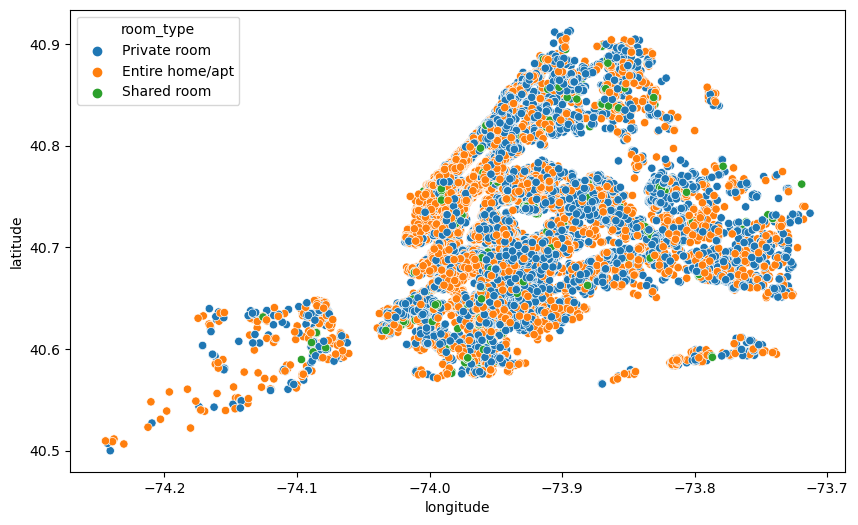

In [80]:
#不同房屋类型的地图
plt.figure(figsize=(10,6))
sns.scatterplot(x=airbnb_nyc.longitude,y=airbnb_nyc.latitude,hue=airbnb_nyc.room_type)
plt.show()

### 地区(neighbourhood group)

如下展示了地区在样本中的频数统计及其频数分布图：

-----Neighbourhood Group-----
Manhattan        21660
Brooklyn         20095
Queens            5666
Bronx             1090
Staten Island      373
Name: neighbourhood_group, dtype: int64
-----------------------------


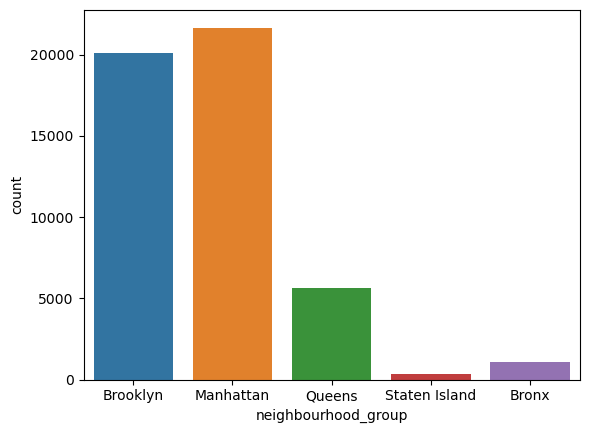

In [72]:
#频数分布
print("-----Neighbourhood Group-----")
print(airbnb_nyc['neighbourhood_group'].value_counts()) #不同neighbourhood group出现的频率
print("-----------------------------")

#频数分布图
ax = sns.countplot(x="neighbourhood_group", data=airbnb_nyc)
plt.show()

下述为依照`地区（neighbourhood group）`绘制的价格的概率分布函数，可以看到不同地区的价格分布不存在明显的差异，这与我们在房屋类型部分分析的最后结果相吻合。

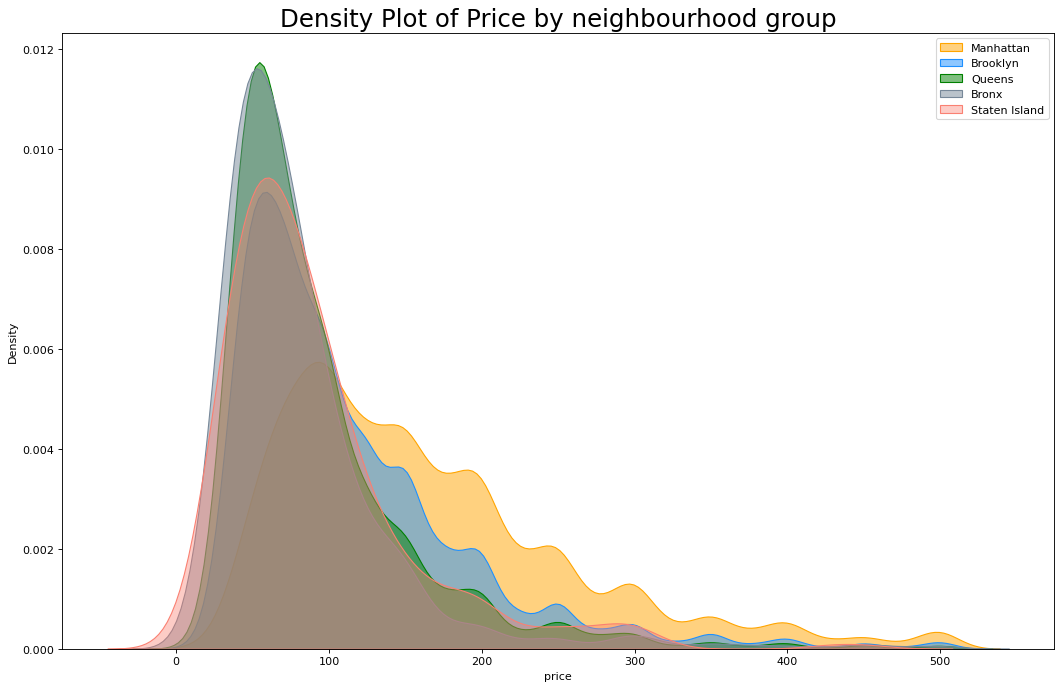

In [76]:
# 密度图
#大部分价格均不超过500，而少数离群值数值偏差较大，会造成很长的拖尾，故我们在此处使用之前构造的nyc数据集

plt.figure(figsize=(16,10),dpi=80)
sns.kdeplot(nyc.loc[nyc['neighbourhood_group']=="Manhattan",'price'],fill=True,color='orange',label = 'Manhattan',alpha=.5)
sns.kdeplot(nyc.loc[nyc['neighbourhood_group']=="Brooklyn",'price'],fill=True,color='dodgerblue',label = 'Brooklyn',alpha=.5)
sns.kdeplot(nyc.loc[nyc['neighbourhood_group']=="Queens",'price'],fill=True,color='g',label = 'Queens',alpha=.5)
sns.kdeplot(nyc.loc[nyc['neighbourhood_group']=="Bronx",'price'],fill=True,color='lightslategrey',label = 'Bronx',alpha=.5)
sns.kdeplot(nyc.loc[nyc['neighbourhood_group']=="Staten Island",'price'],fill=True,color='salmon',label = 'Staten Island',alpha=.4)


plt.title('Density Plot of Price by neighbourhood group', fontsize = 22)
plt.legend()
plt.show()

下述部分展示了不同`地区(neighbourhood group)`在地图上的对应：

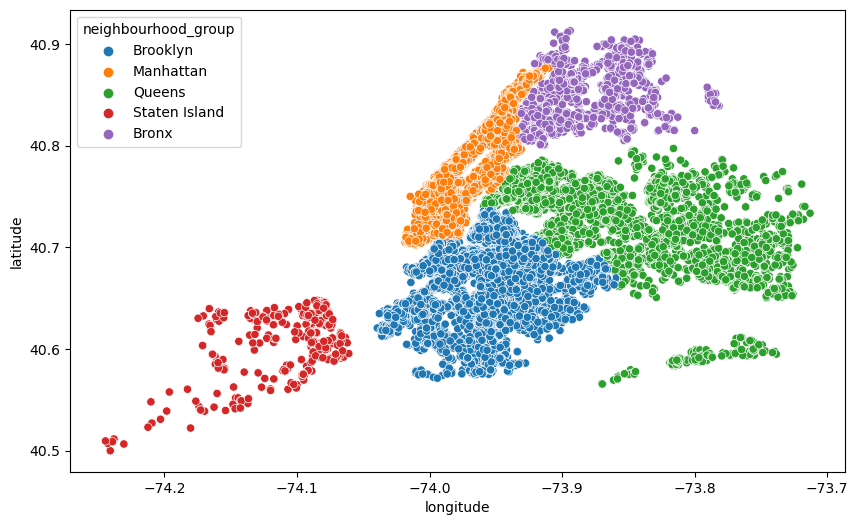

In [86]:
#不同地区的地图

plt.figure(figsize=(10,6))
sns.scatterplot(x=airbnb_nyc.longitude,y=airbnb_nyc.latitude,hue=airbnb_nyc.neighbourhood_group)
plt.show()

## 热力图

为了对上述绘制的地区有更清楚的认识，我们通过热力图来展示数据对应的具体地区：

In [11]:
#热力图
m = folium.Map([40.64749,-73.97237],zoom_start=11)

HeatMap(airbnb_nyc[['latitude','longitude']].dropna(),
        radius=10,
        gradient={0.2:'blue',
        0.4:'purple',
        0.6:'orange',
        1.0:'red'}).add_to(m)
display(m)

## 回归

我们在前述构造的`airbnb_reg`数据集上进行回归，回归变量选择主要依据最前端的协方差矩阵，因为可选择的变量本身较少，故我们依据相关度选择排名靠前的5项。基准模型如下：
$$price = \beta_0 + \beta_1 \cdot neighbourhood~group+\beta_2 \cdot room~type + \beta_3 \cdot minimum~nights + \beta_4 \cdot calculated~host~listings~count + \beta_5 \cdot availability~365 + \epsilon$$

In [90]:
#模型构造
airbnb_reg_result = smf.ols('price ~ neighbourhood_group+room_type+minimum_nights+calculated_host_listings_count+availability_365' , data=airbnb_reg).fit()

#结果展示
print(airbnb_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     504.4
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:24:55   Log-Likelihood:            -3.3608e+05
No. Observations:               48884   AIC:                         6.722e+05
Df Residuals:                   48878   BIC:                         6.722e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

回归结果如上，易知`房屋类型(room type)`对价格有显著的影响，`地区(neighbourhood group)`对价格的影响不显著。结合前述分析，我们可知影响价格的主要因素是`房屋类型(room type)`。